# Neuromodulation example

This neuromodulation creates a small network of neurons. We also use the reaction diffusion model by Anu G Nair 2015.

To generate the ```reaction_diffusion.json``` file in ```data/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20211026/``` from the xml file we run ```data/convert_sbml_to_json.sh```

To get the RxD functionality of the ```DA_syn``` we must specify the "RxD" block in the connectivity block of the network configuration. See ```data/connectivity.json```

```
    "channel_parameters":
		"RxD": {
		    "species_name": "DA",
		    "flux_variable": "open",
		    "region": "internal",
            "weight_scaling": 1e9,
		},

     ...
     }
```

## Network setup

We have two neurons. The first neuron (Neuron 0) receives external input (cortical from t=0s and DA from t=0.1s). The cortical input will activate the first neuron, and through activation of synapses on the second neuron, we will see the dopamine level increase in the second neuron (Neuron 1).

The first neuron also receives direct DA activation from external input (starting at 100ms).

In [1]:
import os
from snudda import Snudda

neuron_path = os.path.join("data", "dspn")
network_path = os.path.join("networks", "neuromodulation_example_anu_with_real_dspn")
connectivity_path = os.path.join("data", "connectivity.json")

snudda = Snudda(network_path=network_path)
si = snudda.init_tiny(neuron_paths=neuron_path, neuron_names="dspn", number_of_neurons=[2], 
                      connection_config=connectivity_path, random_seed=12345)

si.network_data["regions"]["Cube"]["neurons"]["dspn"]["reaction_diffusion"] = "reaction_diffusion.json"

si.write_json()

snudda.create_network()

Reading connectivity from data/connectivity.json
Adding neurons: dspn from dir data/dspn
Writing networks/neuromodulation_example_anu_with_real_dspn/network-config.json
Writing networks/neuromodulation_example_anu_with_real_dspn/network-config.json
Placing neurons
Network path: networks/neuromodulation_example_anu_with_real_dspn
Reading SNUDDA_DATA=None from networks/neuromodulation_example_anu_with_real_dspn/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_example_anu_with_real_dspn/network-synapses.hdf5
No n_putative_points and putative_density, setting n_putative_points = 63
(this must be larger than the number of neurons you want to place)
Generating 63 points for networks/neuromodulation_example_anu_with_real_dspn/mesh/Cube-cube-mesh-2.917951293943981e-05.obj
Filtering, keeping inside points: 4 / 26
neuron_name = 'dspn_0', num = 2, neuron_path = 'data/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20211026'
stop_paralle

In [2]:
input_config = os.path.join("data", "input_v2.json")
snudda.setup_input(input_config=input_config)

Setting up inputs, assuming input.json exists
Reading SNUDDA_DATA=None from networks/neuromodulation_example_anu_with_real_dspn/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_example_anu_with_real_dspn/network-synapses.hdf5
Writing input spikes to networks/neuromodulation_example_anu_with_real_dspn/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/neuromodulation_example_anu_with_real_dspn/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_example_anu_with_real_dspn/network-synapses.hdf5
!!! Warning, combining definition of cortical with cortical input for neuron dspn_0 0 (meta modified by input_config)
Writing spikes to networks/neuromodulation_example_anu_with_real_dspn/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 1.1s


In [3]:
mech_dir = os.path.join("..", "..", "..", "..", "BasalGangliaData", "data", "neurons", "mechanisms")
sample_dt = None # 0.00005
sim = snudda.simulate(time=0, mech_dir=mech_dir, verbose=True, sample_dt=sample_dt)

Using input file networks/neuromodulation_example_anu_with_real_dspn/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64, aarch64, arm64 directories (or nrnmech.dll) then you will force a recompilation of the modules.
Reading SNUDDA_DATA=None from networks/neuromodulation_example_anu_with_real_dspn/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/neuromodulation_example_anu_with_real_dspn/network-synapses.hdf5
Using network_file: networks/neuromodulation_example_anu_with_real_dspn/network-synapses.hdf5
Using input_file: networks/neuromodulation_example_anu_with_real_dspn/input-spikes.hdf5
Using output_file: networks/neuromodulation_example_anu_with_real_dspn/simulation/output.hdf5
Using logFile: networks/neuromodulation_example_anu_with_real_dspn/log/network-simulation-log.txt-0
Worker 0 : Loading network from networks/neuromodulation_example_anu_with_real_

### Add PKA and DA recordings
Here we add recordings from a compartment that receives synaptic input from its neighbour. This has been checked by looking at the synapse_connection matrix (snudda_load command).

In [4]:
sim.add_rxd_concentration_recording(species="PKA", neuron_id=1,
                                    region="dend_internal",
                                    sec_type="dend",
                                    sec_id=4,
                                    sec_x=0.25)

In [5]:
sim.add_rxd_concentration_recording(species="DA", neuron_id=1,
                                    region="dend_internal",
                                    sec_type="dend",
                                    sec_id=4,
                                    sec_x=0.25)

### Add additional PKA and DA recorings, for input

In [6]:
sim.add_rxd_concentration_recording(species="DA", neuron_id=0,
                                    region="dend_internal",
                                    sec_type="dend",
                                    sec_id=7,
                                    sec_x=0.233)

In [7]:
sim.add_rxd_internal_concentration_recording_all(species="PKA", neuron_id=0)

In [8]:
sim.run(t=200)

Running simulation for 0.2 s
Running Neuron simulator 200 ms, with dt=0.025
  1% done. Elapsed: 0.6 s, estimated time left: 64.3 s
  2% done. Elapsed: 1.3 s, estimated time left: 62.9 s
  3% done. Elapsed: 1.9 s, estimated time left: 62.7 s
  4% done. Elapsed: 2.6 s, estimated time left: 61.7 s
  5% done. Elapsed: 3.3 s, estimated time left: 62.3 s
 10% done. Elapsed: 6.4 s, estimated time left: 57.6 s
 20% done. Elapsed: 12.6 s, estimated time left: 50.5 s
 30% done. Elapsed: 18.8 s, estimated time left: 43.9 s
 40% done. Elapsed: 25.0 s, estimated time left: 37.4 s
 50% done. Elapsed: 31.2 s, estimated time left: 31.2 s
 60% done. Elapsed: 37.4 s, estimated time left: 24.9 s
 70% done. Elapsed: 43.6 s, estimated time left: 18.7 s
 80% done. Elapsed: 49.8 s, estimated time left: 12.5 s
 90% done. Elapsed: 56.1 s, estimated time left: 6.2 s
100% done. Elapsed: 62.3 s, estimated time left: 0.0 s
Neuron simulation finished
Simulation done.
Simulation run time: 64.8 s


In [9]:
sim.record.write()

Writing network output to networks/neuromodulation_example_anu_with_real_dspn/simulation/output.hdf5
Using sample dt = None (sample step size None)
Worker 1/1 writing data to networks/neuromodulation_example_anu_with_real_dspn/simulation/output.hdf5


## Load the data and plot

In [10]:
from snudda.utils import SnuddaLoadSimulation

output_file = os.path.join(network_path, "simulation", "output.hdf5")
nd = SnuddaLoadSimulation(output_file)
time = nd.get_time()
data_pka = nd.get_data("PKA", 1)[0][1]
data_da = nd.get_data("DA", 1)[0][1]
data_da_external = nd.get_data("DA", 0)[0][0]

# This is saved with add_rxd_internal_concentration_recording_all -- check that it worked 
data_pka_all0 = nd.get_data("PKA", 0)[0][0]

Loading networks/neuromodulation_example_anu_with_real_dspn/simulation/output.hdf5


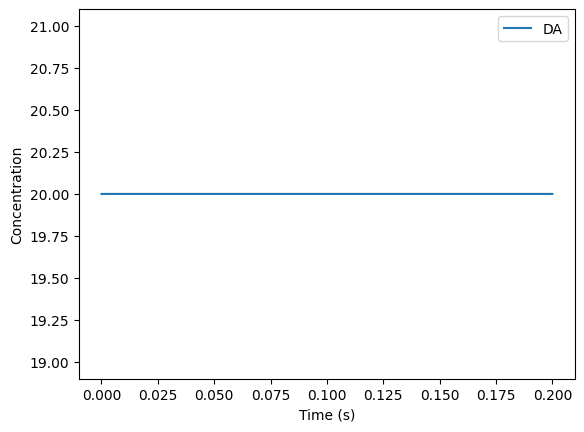

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time, data_da, label="DA")
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

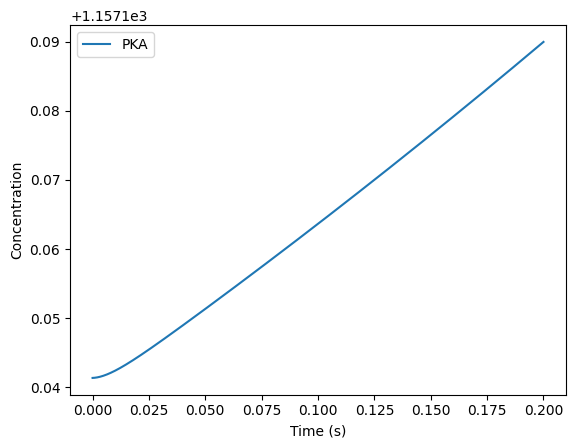

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time, data_pka, label="PKA")
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

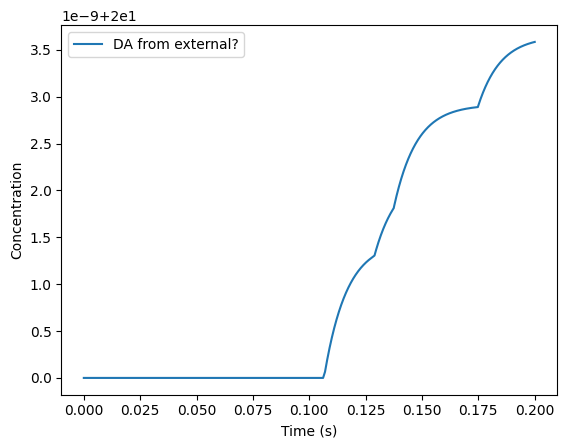

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(time, data_da_external, label="DA from external?")
plt.xlabel("Time (s)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

Loading networks/neuromodulation_example_anu_with_real_dspn/simulation/output.hdf5
Saving figure to networks/neuromodulation_example_anu_with_real_dspn/figures/spike-raster.png


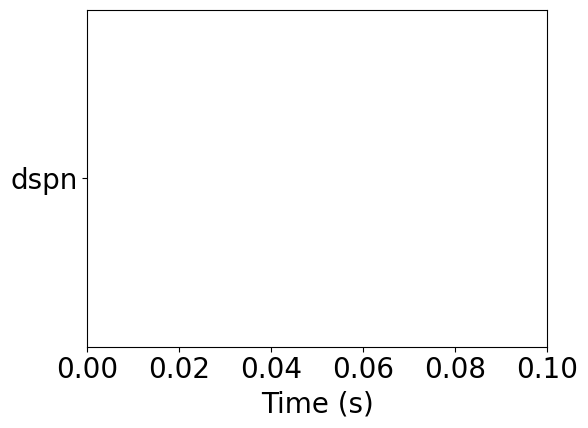

In [14]:
from snudda.plotting import SnuddaPlotSpikeRaster2
fig_file_raster = f"spike-raster.png"

time_range_zoom = (0,0.1)
spr = SnuddaPlotSpikeRaster2(network_path=network_path)

spr.plot_spike_raster(fig_file=fig_file_raster, time_range=time_range_zoom)

Loading network info from networks/neuromodulation_example_anu_with_real_dspn/network-synapses.hdf5
Loading input info from networks/neuromodulation_example_anu_with_real_dspn/input-spikes.hdf5
Loading networks/neuromodulation_example_anu_with_real_dspn/simulation/output.hdf5
Plotting traces: [0, 1]
Plotted 2 traces (total 2)
Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/neuromodulation/networks/neuromodulation_example_anu_with_real_dspn/figures/Network-voltage-trace--dspn-0-1.pdf


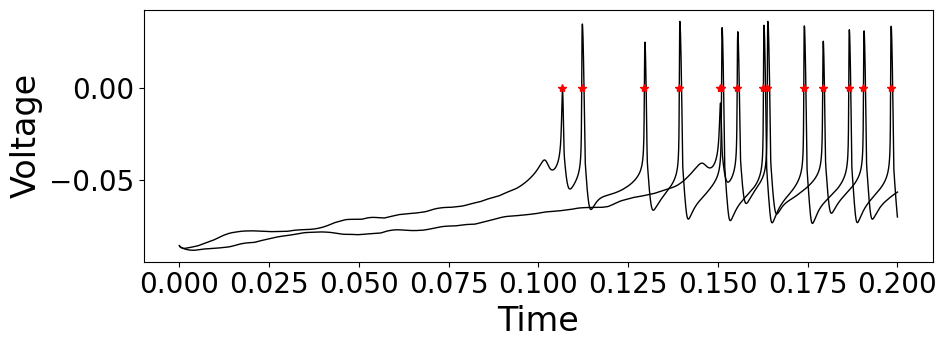

In [15]:
%matplotlib inline

sim_file = os.path.join(network_path, "simulation", "output.hdf5")

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(0,0.5),fig_size=(10,4))

## TODO!! Also add ability to have external synapses affect RxD concentrations

In [16]:
sim.neurons[0].icell.soma[0](0.5).naf_ms.gbar

19.67872706705603

In [17]:
sim.neurons[0].icell.soma[0](0.5).pas.g

0.0005424674497187078